In [40]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [1]:
# Downloading the datasets

import os, zipfile, requests

datasets_zip = "cyberbullying_dataset-mendeley_data.zip"
datasets_dir = "cyberbully_datasets/"
datasets_url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/jf4pzyvnpj-1.zip"

with open("cyberbullying_dataset-mendeley_data.zip", "wb") as rf:
    rf.write(requests.get(datasets_url).content)

if not os.path.exists(datasets_dir):
    os.mkdir(datasets_dir)
    with zipfile.ZipFile(datasets_zip) as zf:
        zf.extractall(datasets_dir)

In [ ]:
# Creating a dataframe for each of the datasets and storing them in a dictionary

datasets = os.listdir("cyberbully_datasets")
dataframes = {}
for dataset in datasets:
    dataframes[dataset.replace(".csv", "")] = pd.read_csv(datasets_dir + dataset)
    dataframes[dataset.replace(".csv", "")] = dataframes[dataset.replace(".csv", "")].dropna()

In [ ]:
# Combining the datasets together

offensive_texts_dataset = pd.DataFrame(columns=["Text", "oh_label"])

for dataframe in dataframes:
    offensive_texts_dataset = pd.concat([offensive_texts_dataset,dataframes[dataframe][["Text", "oh_label"]]], axis=0)
    
offensive_texts_dataset = offensive_texts_dataset.rename(columns={"oh_label":"Offensive"})

In [ ]:
# Shuffling the dataset for creating training and validation splits

import random
sentences = offensive_texts_dataset["Text"].to_numpy()
labels = offensive_texts_dataset["Offensive"].to_numpy()

pairs = list(zip(sentences, labels))
sentences, labels = zip(*pairs)

In [45]:
# Creating training and validation splits

import numpy as np

train_set_size = 0.99

training_shape = int(len(sentences) * train_set_size)
validation_shape = len(sentences) - training_shape

sentences_for_training = sentences[0:training_shape]
labels_for_training = np.array(labels[0:training_shape])

sentences_for_validation = sentences[training_shape:]
labels_for_validation = np.array(labels[training_shape:])

In [46]:
# Creating a word tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<UNK>")
tokenizer.fit_on_texts(sentences_for_training)

In [47]:
# Defining a function for tokenizin and padding words in a sentence

def tokenize_and_pad(texts, tokenizer, maxlen=max_length, padding='post', truncating='post'):
    
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen, padding=padding, truncating=truncating)
    
    return padded_sequences

In [48]:
# Tokenizing and padding the training and validation data

padded_training_sequences = tokenize_and_pad(sentences_for_training, tokenizer)
padded_validation_sequences = tokenize_and_pad(sentences_for_validation, tokenizer)

In [49]:
# Creating a model with TemsprFlow's Sequential API for offensive text sentiment analysis

def create_and_compile_model():

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
    )
    
    return model

In [50]:
model = create_and_compile_model()

In [51]:
# Training the model. Using Early Stopping to stop learning when the validation accuracy stops increasing

num_epochs = 30
batch_size = 64
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3)

history = model.fit(padded_training_sequences,labels_for_training, epochs=num_epochs, batch_size=batch_size,
                    validation_data = (padded_validation_sequences, labels_for_validation), verbose=1, callbacks=[earlyStopping])

Epoch 1/30
6925/6925 [==============================] - 42s 6ms/step - loss: 0.3036 - accuracy: 0.8841 - val_loss: 0.1700 - val_accuracy: 0.9308
Epoch 2/30
6925/6925 [==============================] - 41s 6ms/step - loss: 0.1984 - accuracy: 0.9214 - val_loss: 0.1276 - val_accuracy: 0.9569
Epoch 3/30
6925/6925 [==============================] - 41s 6ms/step - loss: 0.1702 - accuracy: 0.9333 - val_loss: 0.1196 - val_accuracy: 0.9562
Epoch 4/30
6925/6925 [==============================] - 41s 6ms/step - loss: 0.1552 - accuracy: 0.9391 - val_loss: 0.1207 - val_accuracy: 0.9640
Epoch 5/30
6925/6925 [==============================] - 41s 6ms/step - loss: 0.1450 - accuracy: 0.9434 - val_loss: 0.1065 - val_accuracy: 0.9654
Epoch 6/30
6925/6925 [==============================] - 41s 6ms/step - loss: 0.1374 - accuracy: 0.9460 - val_loss: 0.1097 - val_accuracy: 0.9614
Epoch 7/30
6925/6925 [==============================] - 39s 6ms/step - loss: 0.1317 - accuracy: 0.9481 - val_loss: 0.1087 - val_ac

In [65]:
import uuid
uid = str(uuid.uuid1())

if not os.path.exists("models"):
    os.mkdir("models")

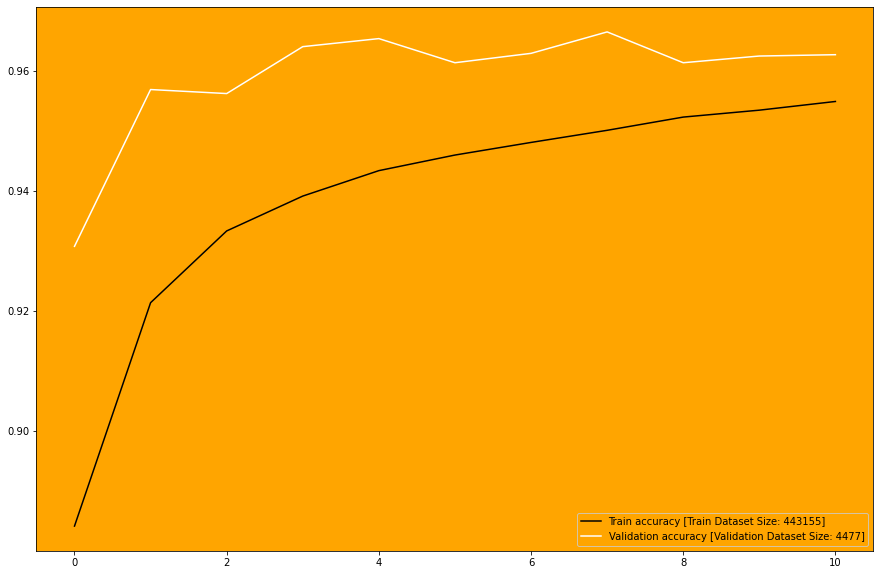

In [70]:
# Plotting the change of accuracy per epoch for both training and validation sets.

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.facecolor']='orange'
plt.figure(figsize=(15,10))
plt.plot(np.arange(0,len(history.history["accuracy"]),1), history.history["accuracy"], c="black")
plt.plot(np.arange(0,len(history.history["val_accuracy"]),1), history.history["val_accuracy"], c="white")
plt.legend(["Train accuracy [Train Dataset Size: {}]".format(training_shape), "Validation accuracy [Validation Dataset Size: {}]".format(validation_shape)])
plt.savefig(os.path.join("models", "change_of_accuracy_plot_{}.jpg".format(uid)))
plt.show()

In [71]:
# Saving the model with a unique ID, so an existing model does not get overwritten

model.save(os.path.join("models", "offensive-text-sentiment-model_{}".format(uid)))

INFO:tensorflow:Assets written to: models/offensive-text-sentiment-model_f4c63934-8e87-11ec-acaa-ab2024bb4aec/assets
